In [1]:
import pandas as pd
import numpy as np
from progress.bar import Bar
#from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

2023-10-29 20:56:14.644420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 20:56:14.644498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 20:56:14.647127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 20:56:14.890973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 20:56:19.189348: W tensorflow/compiler/

In [3]:
df = pd.read_csv("../Metadata/data_curated.csv")
df.set_index("File", inplace=True)
df.head()

,Class
File,
S1V3C1M3A Clip166.npy,1
S1V1C1M1A Clip18.npy,1
S1V4C1M4A Clip241.npy,1
S1V4C1M4A Clip239.npy,1
S1V4C1M4A Clip245.npy,1


In [4]:
X_list = []
y_list = []
with Bar("Processing...", max = df.size) as bar:
    for file_name, class_name in df.iterrows():
        X_list.append(np.load(f"../Clean_Data/{class_name.iloc[0]}/{file_name}")[:33,:])
        y_list.append(class_name.iloc[0])
        bar.next()

In [5]:
min_arr = 1000
for arr in X_list:
    aux_arr = arr.shape[0]
    if aux_arr < min_arr:
        min_arr = aux_arr
print(min_arr)

33


In [6]:
X = np.stack(X_list)
y = np.array(y_list)

In [7]:
X.shape

(1500, 33, 1662)

In [8]:
y.shape

(1500,)

# GaussianHMM

# Recurrent Neural Networks

In [9]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(33,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
y = to_categorical(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
y_test.shape

(450, 6)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 33, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 33, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 596774 (2.28 MB)
Trainable params: 596774 

In [15]:
model.fit(X_train, y_train, epochs=200, batch_size=64)

2023-10-29 20:57:18.834601: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230353200 exceeds 10% of free system memory.


Epoch 1/200
17/17 [==============================] - 11s 222ms/step - loss: 3.5388 - categorical_accuracy: 0.1619
Epoch 2/200
17/17 [==============================] - 4s 254ms/step - loss: 1.7920 - categorical_accuracy: 0.2019
Epoch 3/200
17/17 [==============================] - 4s 225ms/step - loss: 1.3969 - categorical_accuracy: 0.4343
Epoch 4/200
17/17 [==============================] - 4s 227ms/step - loss: 1.1092 - categorical_accuracy: 0.5124
Epoch 5/200
17/17 [==============================] - 4s 225ms/step - loss: 1.0760 - categorical_accuracy: 0.5229
Epoch 6/200
17/17 [==============================] - 4s 233ms/step - loss: 1.0006 - categorical_accuracy: 0.5790
Epoch 7/200
17/17 [==============================] - 4s 224ms/step - loss: 0.7759 - categorical_accuracy: 0.7067
Epoch 8/200
17/17 [==============================] - 4s 227ms/step - loss: 0.6871 - categorical_accuracy: 0.7124
Epoch 9/200
17/17 [==============================] - 4s 238ms/step - loss: 0.6839 - categorical

In [16]:
y_pred = model.predict(X_test)

2023-10-29 21:11:27.641312: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 98722800 exceeds 10% of free system memory.


15/15 [==============================] - 2s 65ms/step


In [17]:
y_pred = np.argmax(y_pred, axis=1).tolist()

In [18]:
y_true = np.argmax(y_test, axis=1).tolist()

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay, confusion_matrix

In [20]:
confusion_matrices = confusion_matrix(y_true, y_pred,labels=np.unique(y_pred), normalize='true')

In [21]:
confusion_matrices

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.03703704, 0.        , 0.96296296, 0.        , 0.        ],
       [0.        , 0.02040816, 0.        , 0.92857143, 0.05102041],
       [0.00990099, 0.00990099, 0.        , 0.04950495, 0.93069307]])

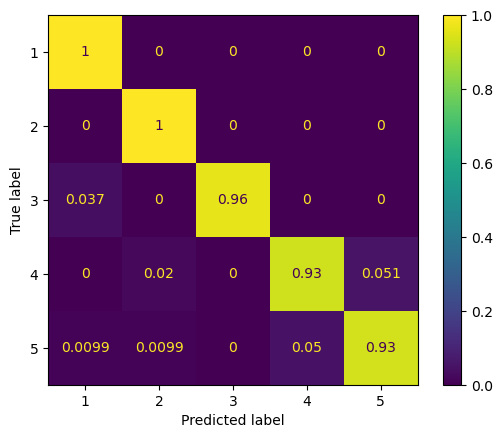

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrices, display_labels=np.unique(y_pred))
disp.plot()

In [24]:
model.save("../Models/rnn33.keras")